In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import time
from matplotlib import rcParams

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(2, 20)
        self.hidden2 = nn.Linear(20, 20)
        self.hidden3 = nn.Linear(20, 20)
        self.hidden4 = nn.Linear(20, 20)
        self.output = nn.Linear(20, 1)

       # Apply Kaiming He initialization
        nn.init.kaiming_normal_(self.hidden1.weight, nonlinearity='tanh')
        nn.init.kaiming_normal_(self.hidden2.weight, nonlinearity='tanh')
        nn.init.kaiming_normal_(self.hidden3.weight, nonlinearity='tanh')
        nn.init.kaiming_normal_(self.hidden4.weight, nonlinearity='tanh')
        nn.init.kaiming_normal_(self.output.weight, nonlinearity='linear')  # Output layer, linear activation

    def forward(self, x):
        x = torch.tanh(self.hidden1(x))
        x = torch.tanh(self.hidden2(x))
        x = torch.tanh(self.hidden3(x))
        x = torch.tanh(self.hidden4(x))
        x = self.output(x)
        return x


In [4]:
# 定义自定义模块用于计算导数
class Dif_u(nn.Module):
    def __init__(self, fnn):
        super(Dif_u, self).__init__()
        self.fnn = fnn
    
    def forward(self, xy):
        x, y = (xy[..., i].unsqueeze(-1) for i in range(xy.shape[-1]))    #x, y = xy[:, 0:1], xy[:, 1:1]
        
        # 需要进行梯度计算
        x.requires_grad_(True)
        y.requires_grad_(True)
        
        temp = self.fnn(torch.cat([x, y], dim=-1))
        u = temp * x
        #u = self.fnn(torch.cat([x, y], dim=1)) * x
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]   #, create_graph=True
        u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_xy = torch.autograd.grad(u_x, y, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
        
        return u_x, u_y, u_xx, u_xy, u_yy

In [5]:
class Dif_v(nn.Module):
    def __init__(self, fnn):
        super(Dif_v, self).__init__()
        self.fnn = fnn
    
    def forward(self, xy):
        x, y = (xy[..., i].unsqueeze(-1) for i in range(xy.shape[-1]))   #x, y = xy[:, 0:1], xy[:, 1:1]

        # 需要进行梯度计算 x.requires_grad_(True)
        x.requires_grad_(True)
        y.requires_grad_(True)        
        
        v = self.fnn(torch.cat([x, y], dim=-1))
        v_x = torch.autograd.grad(v, x, grad_outputs=torch.ones_like(v), create_graph=True)[0]  #, create_graph=True
        v_y = torch.autograd.grad(v, y, grad_outputs=torch.ones_like(v), create_graph=True)[0]
        v_xx = torch.autograd.grad(v_x, x, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
        v_xy = torch.autograd.grad(v_x, y, grad_outputs=torch.ones_like(v_x), create_graph=True)[0]
        v_yy = torch.autograd.grad(v_y, y, grad_outputs=torch.ones_like(v_y), create_graph=True)[0]
        
        return v_x, v_y, v_xx, v_xy, v_yy

In [6]:
class PINN(nn.Module):
    def __init__(self, net1, net2, mu):
        super(PINN, self).__init__()
        #self.net1 = net1
        #self.net2 = net2
        self.mu = mu
        self.Dif1 = Dif_u(net1)
        self.Dif2 = Dif_v(net2)
       
    #def forward(self, x):
    #    u_x, u_y, u_xx, u_xy, u_yy = self.dif_u(x)
    #    v_x, v_y, v_xx, v_xy, v_yy = self.dif_v(x)


    #    gex = (2 * nu + la) * u_xx + nu * u_yy + (nu + la) * v_xy
    #    gey = (nu + la) * u_xy + (2 * nu + la) * v_yy + nu * v_xx

    #    return u, v, gex, gey

    #def forward(self, xy, xy_u, xy_b, xy_l, xy_r):
    def forward(self, x_train):
        # 从 x_train 中提取 xy, xy_u, xy_b, xy_l, xy_r
        xy = x_train[0]
        xy_u = x_train[1]
        xy_b = x_train[2]
        xy_l = x_train[3]
        xy_r = x_train[4]
        
        # Obtain partial derivatives with respect to x and y
        U_x, U_y, U_xx, U_xy, U_yy = self.Dif1(xy)
        V_x, V_y, V_xx, V_xy, V_yy = self.Dif2(xy)
        U_u_x, U_u_y, U_u_xx, U_u_xy, U_u_yy = self.Dif1(xy_u)
        V_u_x, V_u_y, V_u_xx, V_u_xy, V_u_yy = self.Dif2(xy_u)
        U_b_x, U_b_y, U_b_xx, U_b_xy, U_b_yy = self.Dif1(xy_b)
        V_b_x, V_b_y, V_b_xx, V_b_xy, V_b_yy = self.Dif2(xy_b)
        U_l_x, U_l_y, U_l_xx, U_l_xy, U_l_yy = self.Dif1(xy_l)
        V_l_x, V_l_y, V_l_xx, V_l_xy, V_l_yy = self.Dif2(xy_l)
        U_r_x, U_r_y, U_r_xx, U_r_xy, U_r_yy = self.Dif1(xy_r)
        V_r_x, V_r_y, V_r_xx, V_r_xy, V_r_yy = self.Dif2(xy_r)
        #t = self.net2(xy_r)


        la = self.mu / (1 + self.mu) / (1 - 2 * self.mu)
        nu = 1 / (1 + self.mu) / 2

        ### Obtain the residuals from stress boundary conditions
        s_u_x = nu * U_u_y + nu * V_u_x
        s_u_y = (2 * nu + la) * V_u_y + la * U_u_x
        s_b_x = nu * U_b_y + nu * V_b_x
        s_b_y = (2 * nu + la) * V_b_y + la * U_b_x
        s_l_y = nu * U_l_y + nu * V_l_x
        s_r_y = nu * U_r_y + nu * V_r_x
        s_l_x = (2 * nu + la) * U_l_x + la * V_l_y
        s_r_x = (2 * nu + la) * U_r_x + la * V_r_y

        ### Obtain the residuals from equilibrium equation
        Gex = (2 * nu + la) * U_xx + nu * U_yy + (nu + la) * V_xy
        Gey = (nu + la) * U_xy + (2 * nu + la) * V_yy + nu * V_xx     

        return Gex, Gey, s_u_x, s_u_y, s_b_x, s_b_y, s_l_x, s_l_y, s_r_x, s_r_y   
        

In [7]:
class Opt_lbfgsb:
    def __init__(self, pinn, x_train, y_train, dx, h, factr=10, pgtol=1e-10, m=50, maxls=50, maxiter=20000):
        self.pinn = pinn
        #self.x_train = [torch.tensor(x, dtype=torch.float32, requires_grad=True) for x in x_train]
        #self.y_train = [torch.tensor(y, dtype=torch.float32) for y in y_train]
        #self.x_train = [x.clone().detach().requires_grad_(True) if isinstance(x, torch.Tensor) else torch.tensor(x, dtype=torch.float32, requires_grad=True) for x in x_train]
        #self.y_train = [y.clone().detach() if isinstance(y, torch.Tensor) else torch.tensor(y, dtype=torch.float32) for y in y_train]
        self.x_train =  x_train
        self.y_train =  y_train
        
        #self.x_train = [torch.tensor(x, dtype=torch.float32) for x in x_train]
        #self.y_train = [torch.tensor(y, dtype=torch.float32) for y in y_train]
        #self.x_train = [x.clone().detach().float() for x in x_train]
        #self.y_train = [y.clone().detach().float() for y in y_train]
     
        
        self.dx = dx
        self.h = h
        self.factr = factr
        self.pgtol = pgtol
        self.m = m
        self.maxls = maxls
        self.maxiter = maxiter
        self.metrics = ['loss']

    def set_weights(self, flat_weights):
        shapes = [w.shape for w in self.pinn.parameters()]
        split_sizes = [np.prod(shape) for shape in shapes]
        split_ids = np.cumsum([0] + split_sizes)

        #split_ids = [0] + [torch.tensor(np.prod(shape)).int() for shape in shapes]
        weights = [torch.tensor(flat_weights[from_id:to_id], dtype=torch.float32).reshape(shape)
                   for from_id, to_id, shape in zip(split_ids[:-1], split_ids[1:], shapes)]
        
        # Print out shapes and parameter names for debugging
        #for i, (name, param) in enumerate(self.pinn.named_parameters()):
        #    print(f"Setting weight for {name}: expected shape {param.shape}, got shape {weights[i].shape}")
        
        state_dict = {name: weights[i] for i, (name, _) in enumerate(self.pinn.named_parameters())}
        self.pinn.load_state_dict(state_dict)
        #self.pinn.load_state_dict({name: weights[i] for i, (name, _) in enumerate(self.pinn.named_parameters())})

        
        
        #split_ids = np.cumsum([np.prod(shape) for shape in shapes])
        #split_weights = np.split(flat_weights, split_ids[:-1])
        #for param, weight in zip(self.pinn.parameters(), split_weights):
        #    param.data = torch.tensor(weight, dtype=param.data.dtype).reshape(param.shape)

    #def Loss_grad(self, x, y):
    #    u, v, gex, gey = self.pinn(x)
    #    loss1 = self.h * self.dx ** 2 * (torch.sum(gex ** 2) + torch.sum(gey ** 2))
    #    loss2 = self.dx * (torch.sum((u - y[0]) ** 2) + torch.sum((v - y[1]) ** 2))
    #    loss = loss1 + loss2
    #    grads = torch.autograd.grad(loss, self.pinn.parameters(), create_graph=True)
    #    return loss.item(), np.concatenate([g.detach().numpy().flatten() for g in grads])

    def Loss_grad(self, x, y):
        #x = torch.stack(x)
        #y = torch.stack(y)
        
        with torch.enable_grad():
            outputs = self.pinn(x)
            l1 = self.h * self.dx ** 2 * (torch.sum(torch.square(outputs[0])) +
                                            torch.sum(torch.square(outputs[1])))
            l2 = (self.dx * (torch.sum(torch.square(outputs[2]-y[0])) +
                                torch.sum(torch.square(outputs[3]-y[1]))) +
                    self.dx * (torch.sum(torch.square(outputs[4]-y[2])) +
                                torch.sum(torch.square(outputs[5]-y[3]))) +
                    self.dx * (torch.sum(torch.square(outputs[7]-y[5]))) +
                    self.dx * (torch.sum(torch.square(outputs[8]-y[6]))) +
                    self.dx * (torch.sum(torch.square(outputs[9]-y[7]))))
            #l3 = 0 * torch.sum(outputs[10])
            #loss = l1 + l2 + l3
            loss = l1 + l2 
        # grads = torch.autograd.grad(loss, self.pinn.parameters(), create_graph=True )  #create_graph=True
        grads = torch.autograd.grad(loss, self.pinn.parameters(), create_graph=True, allow_unused=True)
        
        return loss, grads, l1, l2

    '''
    def Loss(self, weights):
        self.set_weights(weights)
        loss, grads, l1, l2 = self.Loss_grad(self.x_train, self.y_train)
        # print('L1 =',l1.numpy(),'   L2 =',l2.numpy(),'')
        print('L1 =', l1.detach().numpy(), '   L2 =', l2.detach().numpy(), '')
        # loss = loss.numpy().astype('float64')
        loss = loss.detach().numpy().astype('float64')
        # grads = np.concatenate([ g.numpy().flatten() for g in grads ]).astype('float64')
        # grads = np.concatenate([g.detach().numpy().flatten() for g in grads]).astype('float64')
        grads = np.concatenate([g.detach().numpy().flatten() if g is not None else np.zeros_like(p.detach().numpy().flatten())
                                for g, p in zip(grads, self.pinn.parameters())]).astype('float64')
        #loss = loss.item()
        #grads = torch.cat([g.flatten() for g in grads])
        return loss, grads
    '''
    # 先转cpu
    def Loss(self, weights):
        self.set_weights(weights)
        loss, grads, l1, l2 = self.Loss_grad(self.x_train, self.y_train)
        print('L1 =', l1.detach().cpu().numpy(), '   L2 =', l2.detach().cpu().numpy(), '   Loss =', loss.detach().cpu().numpy())
        loss = loss.detach().cpu().numpy().astype('float64')
        grads = np.concatenate([g.detach().cpu().numpy().flatten() if g is not None else np.zeros_like(p.detach().cpu().numpy().flatten())
                                for g, p in zip(grads, self.pinn.parameters())]).astype('float64')
        return loss, grads
    def fit(self):
        # initial_weights = torch.cat([w.flatten() for w in self.pinn.parameters()]).detach().numpy()  #.detach().numpy()
        initial_weights = torch.cat([w.flatten().cpu() for w in self.pinn.parameters()]).detach().numpy()
        #initial_weights = np.concatenate([param.detach().numpy().flatten() for param in self.pinn.parameters()])
        result = scipy.optimize.fmin_l_bfgs_b(func=self.Loss, x0=initial_weights, 
                                              factr=self.factr, pgtol=self.pgtol, 
                                              m=self.m, maxls=self.maxls, 
                                              maxiter=self.maxiter)
        return result


In [8]:
# 设置字体为新罗马字体
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']

# 定义坐标边界
xmin, xmax = -0.01, 0.51
ymin, ymax = -0.075, 0.075

# 保存图像的路径
save_path = './GPU/'

def Vis(E, pinn, net1, net2, xy, T, L, it):
    """
    =================================================================================================================================
    
    Options:
        Name        Type                    Size        Info.
        
        'E'         [float]                 1           : 杨氏模量（Young's module）;
        'pinn'      [torch nn.Module]       \           : 已训练的物理信息神经网络（PINN）;
        'net1'      [torch nn.Module]       \           : 用于位移 u 的已训练前馈神经网络（FNN）;
        'net2'      [torch nn.Module]       \           : 用于位移 v 的已训练前馈神经网络（FNN）;
        'xy'        [Array of float32]      ns*2        : 可视化的采样点坐标。
        
    Variables:
        Name        Type                    Size        Info.
        
        [u]         [Array of float32]      ns*1        : 位移 u;
        [v]         [Array of float32]      ns*1        : 位移 v;
        [s11]       [Array of float32]      ns*1        : 正应力 σ_x;
        [s22]       [Array of float32]      ns*1        : 正应力 σ_y;
        [s12]       [Array of float32]      ns*1        : 剪应力 τ_xy。

    =================================================================================================================================    
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # 生成网格点坐标
    xy = np.zeros((201*41, 2)).astype(np.float32)  #xy = np.zeros((101*21, 2)).astype(np.float32)
    for i in range(0, 201):
        for j in range(0, 41):
            xy[i*41+j, 0] = i * 0.5/200
            xy[i*41+j, 1] = j * 0.5/200 - 0.05

    xy_tensor = torch.tensor(xy).float().to(device)

    # 预测位移 u
    #u = net1(xy_tensor).detach().numpy() * xy[..., 0, np.newaxis]
    u = net1(xy_tensor).detach().cpu().numpy() * xy[..., 0, np.newaxis]

    # 预测位移 v
    #v = net2(xy_tensor).detach().numpy() - net2(torch.tensor([[0., 0.]]).float()).detach().numpy()
    v = net2(xy_tensor).detach().cpu().numpy() - net2(torch.tensor([[0., 0.]]).float().to(device)).detach().cpu().numpy()  # Ensure all tensors are on the same device before the operation

    # 使用 PINN 预测应力
    temp = pinn([xy_tensor for _ in range(5)])
    s11 = temp[8].detach().cpu().numpy() * E
    s22 = temp[3].detach().cpu().numpy() * E
    s12 = temp[2].detach().cpu().numpy() * E
    
    # 绘制位移 u 的等值图
    fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(20, 10))
    fig.subplots_adjust(hspace=0.3, wspace=0.05)

    #fig1 = plt.figure(1, figsize = (10, 5))
    cf = ax[0,0].scatter(xy[:, 0], xy[:, 1], s=5, c=u, cmap='Spectral', vmin=-0.0228, vmax=0.0228)
    ax[0,0].axis('equal')
    plt.colorbar(cf, ax=ax[0,0])
    ax[0,0].set_xlim([xmin, xmax])
    ax[0,0].set_ylim([ymin, ymax])
    ax[0,0].set_title('u')
    ax[0,0].set_xlabel('x (m)')
    #plt.savefig(fig_save_path + 'u.png', dpi=600)

    # 绘制位移 v 的等值图
    #fig2 = plt.figure(2, figsize = (10, 5))
    cf = ax[0,1].scatter(xy[:, 0], xy[:, 1], s=5, c=v, cmap='Spectral', vmin=-0.1138, vmax=0)
    ax[0,1].axis('equal')
    plt.colorbar(cf, ax=ax[0,1])
    ax[0,1].set_xlim([xmin, xmax])
    ax[0,1].set_ylim([ymin, ymax])
    ax[0,1].set_title('v')
    ax[0,1].set_xlabel('x (m)')
    #plt.savefig(fig_save_path + 'v.png', dpi=600)
    
    # 绘制正应力 σ_x 的等值图
    #fig3 = plt.figure(3, figsize = (10, 5))
    cf = ax[1,0].scatter(xy[:, 0], xy[:, 1], s=5, c=s11, cmap='Spectral', vmin=-50, vmax=50)
    ax[1,0].axis('equal')
    plt.colorbar(cf, ax=ax[1,0])
    ax[1,0].set_xlim([xmin, xmax])
    ax[1,0].set_ylim([ymin, ymax])
    ax[1,0].set_title(r'$\sigma_{x}$')
    ax[1,0].set_xlabel('x (m)')
    #plt.savefig(fig_save_path + 'sigma_x.png', dpi=600)
    
    # 绘制正应力 σ_y 的等值图
    #fig4 = plt.figure(4, figsize = (10, 5))
    cf = ax[1,1].scatter(xy[:, 0], xy[:, 1], s=5, c=s22, cmap='Spectral', vmin=-2, vmax=2)
    ax[1,1].axis('equal')
    plt.colorbar(cf, ax=ax[1,1])
    ax[1,1].set_xlim([xmin, xmax])
    ax[1,1].set_ylim([ymin, ymax])    
    ax[1,1].set_title(r'$\sigma_{y}$')
    ax[1,1].set_xlabel('x (m)')
    #plt.xlim(xmin1, xmax1)
    #plt.ylim(ymin1, ymax1)
    #plt.savefig(fig_save_path + '11.png', dpi=600)
    #fig.savefig(fig_save_path + "LLL.png", dpi=600)
    
    # 绘制剪应力 τ_xy 的等值图
    #fig5 = plt.figure(5, figsize = (10, 5))
    cf = ax[2,0].scatter(xy[:, 0], xy[:, 1], s=5, c=s12, cmap='Spectral', vmin=-2, vmax=2)
    ax[2,0].axis('equal')
    plt.colorbar(cf, ax=ax[2,0])
    ax[2,0].set_xlim([xmin, xmax])
    ax[2,0].set_ylim([ymin, ymax]) 
    ax[2,0].set_title(r'$\tau_{xy}$')
    ax[2,0].set_xlabel('x (m)')

    cf = ax[2,1].scatter(xy[:, 0], xy[:, 1], s=0)
    ax[2,1].axis('off')  # 关闭轴线
    fig.savefig(save_path + "LLL.png", dpi=1200)
    #plt.savefig(fig_save_path + 'tau_xy.png', dpi=600)
    
    # 将数据输出到 'out.mat' 文件中
    scipy.io.savemat(save_path + 'out.mat', {'xy': xy, 'u': np.hstack([u, v]), 's11': s11, 's22': s22, 's12': s12, 'T': T, 'L': L, 'it': it})


In [9]:
def Input():
    """
    =================================================================================================================================

    Variables:
        Name        Type                    Size        Info.
        
        [ns]        [int]                   1           : Total number of sample points;
        [ns_u]      [int]                   1           : Number of sample points on top boundary of the beam;
        [ns_l]      [int]                   1           : Number of sample points on left boundary of the beam;
        [dx]        [float]                 1           : Sample points interval;
        [h]         [float]                 1           : Parameter relates to sample points interval;
        [xy]        [Array of float32]      ns*2        : Coordinates of all the sample points;
        [xy_u]      [Array of float32]      ns_u*2      : Coordinates of the sample points on the top boundary of the beam;
        [xy_b]      [Array of float32]      ns_u*2      : Coordinates of the sample points on the bottom boundary of the beam;
        [xy_l]      [Array of float32]      ns_l*2      : Coordinates of the sample points on the left boundary of the beam;
        [xy_r]      [Array of float32]      ns_l*2      : Coordinates of the sample points on the right boundary of the beam;
        [x_train]   [List]                  5           : PINN input list, contains all the coordinates information;
        [s_u_x]     [Array of float32]      ns_u*1      : x direction force boundary condition on the top boundary of the beam;
        [s_u_y]     [Array of float32]      ns_u*1      : y direction force boundary condition on the top boundary of the beam;
        [s_b_x]     [Array of float32]      ns_u*1      : x direction force boundary condition on the bottom boundary of the beam;
        [s_b_y]     [Array of float32]      ns_u*1      : y direction force boundary condition on the bottom boundary of the beam;
        [s_l_x]     [Array of float32]      ns_l*1      : x direction force boundary condition on the left boundary of the beam;
        [s_l_y]     [Array of float32]      ns_l*1      : y direction force boundary condition on the left boundary of the beam;
        [s_r_x]     [Array of float32]      ns_l*1      : x direction force boundary condition on the right boundary of the beam;
        [s_r_y]     [Array of float32]      ns_l*1      : y direction force boundary condition on the right boundary of the beam;
        [y_train]   [List]                  8           : PINN boundary condition list, contains all the force boundary conditions;
        [E]         [float]                 1           : Young's module;
        [mu]        [float]                 1           : Poisson ratio.
        
    =================================================================================================================================    
    """
    print('-------------------------------------------------\n')
    print('                 Input Info.\n')
    print('-------------------------------------------------\n')

    # number of sample points
    ns = 2121   #561
    ns_u = 101  #51
    ns_l = 21  #11

    # sample points' interval
    dx = 0.005   #0.01
    h = 100*dx

    print(ns, 'sample points')
    print(ns_u,'sample points on the top boundary;',ns_u,'sample points on the bottom boundary;')
    print(ns_l,'sample points on the left boundary;',ns_l,'sample points on the right boundary.')

    # initialize sample points' coordinates    
    xy = np.zeros((ns, 2)).astype(np.float32)
    for i in range(0, ns_u):
        for j in range(0, ns_l):
            xy[i*ns_l+j, 0] = i * dx
            xy[i*ns_l+j, 1] = j * dx - 0.1
    xy_u = np.hstack([np.linspace(0, 0.5, ns_u).reshape(ns_u, 1).astype(np.float32), \
                        0.05 * np.ones((ns_u, 1)).astype(np.float32)])
    xy_b = np.hstack([np.linspace(0, 0.5, ns_u).reshape(ns_u, 1).astype(np.float32), \
                        -0.05 * np.ones((ns_u, 1)).astype(np.float32)])
    xy_l = np.hstack([np.zeros((ns_l, 1)).astype(np.float32), \
                        np.linspace(-0.05, 0.05, ns_l).reshape(ns_l, 1).astype(np.float32)])
    xy_r = np.hstack([0.5 * np.ones((ns_l, 1)).astype(np.float32), \
                        np.linspace(-0.05, 0.05, ns_l).reshape(ns_l, 1).astype(np.float32)])

    # create PINN input list
    x_train = [torch.tensor(xy, dtype=torch.float32), # requires_grad=True
                torch.tensor(xy_u, dtype=torch.float32),
                torch.tensor(xy_b, dtype=torch.float32),
                torch.tensor(xy_l, dtype=torch.float32),
                torch.tensor(xy_r, dtype=torch.float32)]

    #x_train = {
    #    'xy': torch.tensor(xy, dtype=torch.float32),
    #    'xy_u': torch.tensor(xy_u, dtype=torch.float32),
    #    'xy_b': torch.tensor(xy_b, dtype=torch.float32),
    #    'xy_l': torch.tensor(xy_l, dtype=torch.float32),
    #    'xy_r': torch.tensor(xy_r, dtype=torch.float32)
    #}

    # material properties
    E = 1000.
    mu = 0.3
    print('The Young''s module is', E, '; The Poisson''s ratio is', mu, '.\n')
    print('-------------------------------------------------\n')

    # boundary conditions
    s_u_x = np.zeros((ns_u, 1)).astype(np.float32)
    s_u_y = np.zeros((ns_u, 1)).astype(np.float32)
    s_b_x = np.zeros((ns_u, 1)).astype(np.float32)
    s_b_y = np.zeros((ns_u, 1)).astype(np.float32)
    s_l_x = np.zeros((ns_l, 1)).astype(np.float32)
    s_l_y = np.zeros((ns_l, 1)).astype(np.float32)
    s_r_x = xy_r[:, 1, np.newaxis] * 1000
    s_r_y = np.zeros((ns_l, 1)).astype(np.float32)

    # create PINN boundary condition list
    y_train = [torch.tensor(s_u_x / E, dtype=torch.float32),
                torch.tensor(s_u_y / E, dtype=torch.float32),
                torch.tensor(s_b_x / E, dtype=torch.float32),
                torch.tensor(s_b_y / E, dtype=torch.float32),
                torch.tensor(s_l_x / E, dtype=torch.float32),
                torch.tensor(s_l_y / E, dtype=torch.float32),
                torch.tensor(s_r_x / E, dtype=torch.float32),
                torch.tensor(s_r_y / E, dtype=torch.float32)]

    return ns, ns_u, ns_l, x_train, y_train, E, mu, dx, h


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 假设Net和PINN类已经定义
net_u = Net().to(device)
net_v = Net().to(device)
pinn = PINN(net_u, net_v, mu=0.3).to(device)


#x_train = [...]  # Your training data here
#y_train = [...]  # Your training data here

ns, ns_u, ns_l, x_train, y_train, E, mu, dx, h = Input()

# 将所有张量数据转移到GPU
#x_train = {key: val.to(device) for key, val in x_train.items()}
# y_train 是列表，需要遍历并转移到 GPU
#y_train = [val.to(device) for val in y_train]

# 将所有张量数据转移到GPU
x_train = [val.to(device) for val in x_train]
# y_train 是列表，需要遍历并转移到 GPU
y_train = [val.to(device) for val in y_train]


l_bfgs_b = Opt_lbfgsb(pinn, x_train, y_train, dx, h)
time_start = time.time()
result = l_bfgs_b.fit()
time_end = time.time()
T = time_end-time_start
L = result[1]
it = result[2]['funcalls']
print('-------------------------------------------------\n')
print('Time cost is', T, 's')
print('Final loss is', L, '')
print('Training converges by', it, 'iterations\n')
print('-------------------------------------------------\n')
#train_model(pinn, l_bfgs_b, x_train, y_train, dx, h)


-------------------------------------------------

                 Input Info.

-------------------------------------------------

2121 sample points
101 sample points on the top boundary; 101 sample points on the bottom boundary;
21 sample points on the left boundary; 21 sample points on the right boundary.
The Youngs module is 1000.0 ; The Poissons ratio is 0.3 .

-------------------------------------------------

L1 = 1.5047897    L2 = 0.82179046    Loss = 2.32658
L1 = 0.9574025    L2 = 1.8745562    Loss = 2.8319588
L1 = 1.3289251    L2 = 0.48381206    Loss = 1.8127372
L1 = 0.23987658    L2 = 0.18473376    Loss = 0.42461035
L1 = 0.055651184    L2 = 0.064083785    Loss = 0.11973497
L1 = 0.045249812    L2 = 0.048891403    Loss = 0.094141215
L1 = 0.029213373    L2 = 0.03795948    Loss = 0.067172855
L1 = 0.021555677    L2 = 0.020739796    Loss = 0.04229547
L1 = 0.023073198    L2 = 0.009639138    Loss = 0.032712337
L1 = 0.017853426    L2 = 0.008882458    Loss = 0.026735883
L1 = 0.014285

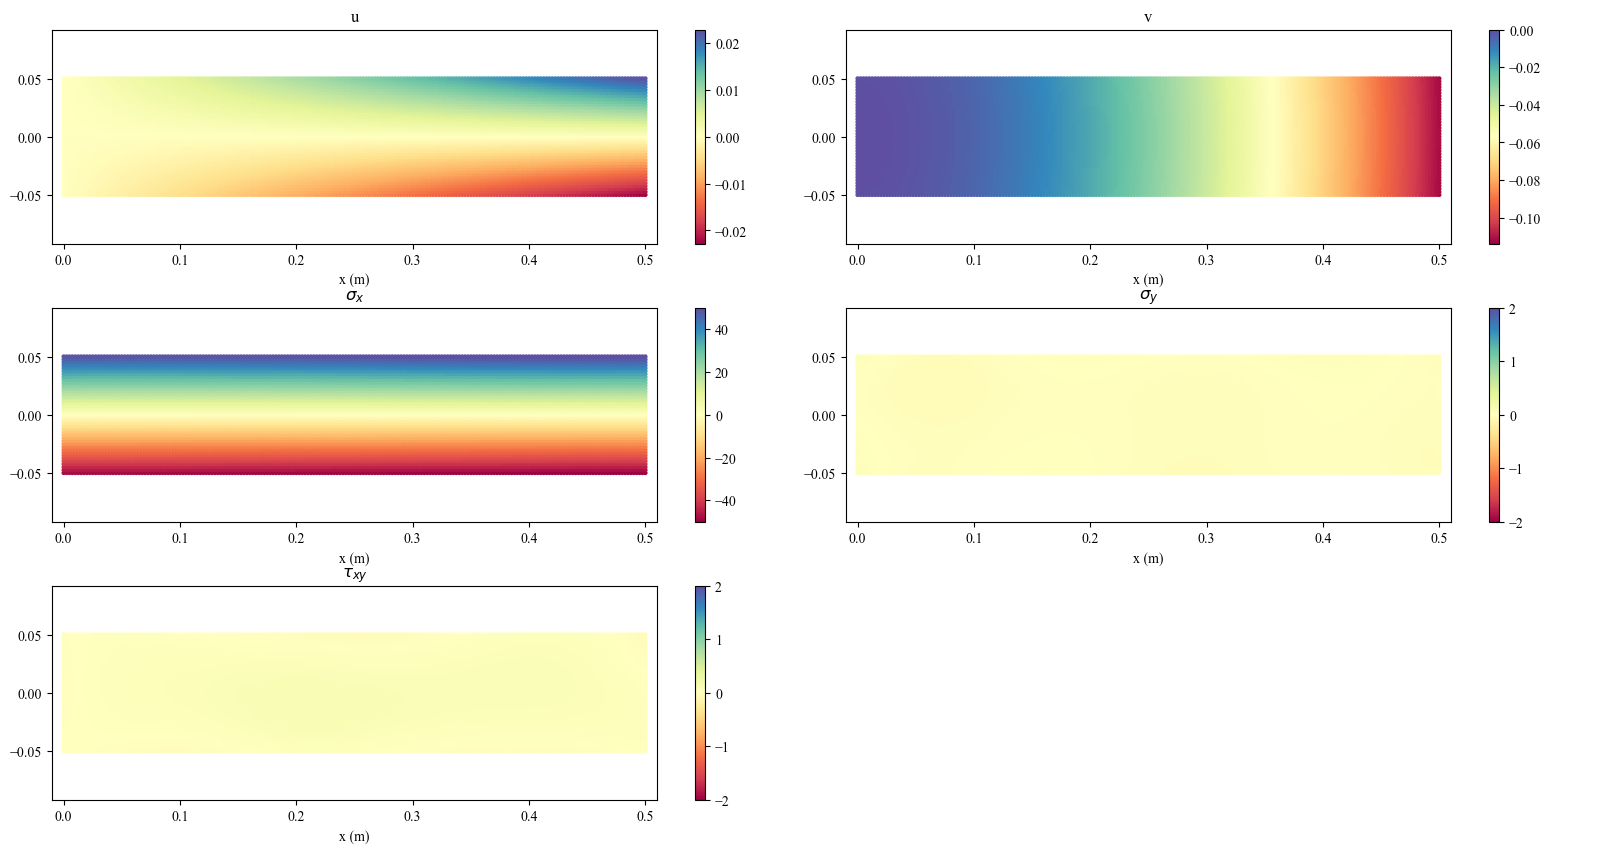

In [11]:
"""

        Visualize the results
    
"""

Vis(E, pinn, net_u, net_v, x_train[0], T, L, it)    #x_train[0]